# NYC Rat Sightings Hot Spot Classifier
## Machine Learning Pipeline for Predicting Rat Infestation Hot Spots in New York City

---

**Project Overview**
This notebook implements a comprehensive machine learning pipeline to predict rat infestation hot spots across NYC ZIP codes using 311 service request data. The project employs supervised classification to identify areas requiring prioritized pest control intervention.

**Key Objectives**
- **Predict Hot Spots**: Classify ZIP codes as rat infestation hot spots (top 10% by sighting frequency)
- **Compare Models**: Evaluate Logistic Regression vs. Multi-Layer Perceptron (MLP) architectures
- **Feature Engineering**: Extract meaningful predictors from temporal, geographic, and service data
- **Business Impact**: Enable data-driven resource allocation for NYC pest control operations

 **Methodology**
- **Data Source**: NYC 311 Service Requests - Rat Sightings
- **Target Definition**: Top 10% of ZIP codes by rat sighting density (90th percentile threshold)
- **Features**: Borough, location type, coordinates, seasonal patterns, response times
- **Models**: Logistic Regression baseline + 5 MLP architectures
- **Validation**: 5-fold stratified cross-validation with 80/20 train-test split

In [ ]:
# Imports 
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Data Load / Check
df = pd.read_csv('Rat_Sightings.csv')

df.info()
df.groupby('Incident Zip')['Unique Key'].nunique().sort_values(ascending=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101914 entries, 0 to 101913
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unique Key                      101914 non-null  int64  
 1   Created Date                    101914 non-null  object 
 2   Closed Date                     90983 non-null   object 
 3   Agency                          101914 non-null  object 
 4   Agency Name                     101914 non-null  object 
 5   Complaint Type                  101914 non-null  object 
 6   Descriptor                      101914 non-null  object 
 7   Location Type                   101908 non-null  object 
 8   Incident Zip                    101578 non-null  float64
 9   Incident Address                92840 non-null   object 
 10  Street Name                     92839 non-null   object 
 11  Cross Street 1                  85257 non-null   object 
 12  Cross Street 2  

(101914, 52)

In [3]:
# Creating a hot spot classification based on the top 10% of rat sightings

# Create zip code hot spot classification based on top 10% of rat sightings
zip_counts = df.groupby('Incident Zip')['Unique Key'].nunique().sort_values(ascending=False)

# Calculate the 90th percentile threshold (top 10%)
threshold_90th = zip_counts.quantile(0.9)
print(f"90th percentile threshold: {threshold_90th:.1f} rat sightings")

# Number of zip codes in top 10%
total_zip_codes = len(zip_counts)
top_10_percent_count = int(total_zip_codes * 0.1)
print(f"Total zip codes: {total_zip_codes}")
print(f"Top 10% equals: {top_10_percent_count} zip codes")

# Create hot spot classification
zip_counts_df = zip_counts.reset_index()
zip_counts_df.columns = ['Incident_Zip', 'Rat_Sighting_Count']

# Add hot spot classification column
zip_counts_df['Is_Hot_Spot'] = zip_counts_df['Rat_Sighting_Count'] >= threshold_90th
zip_counts_df['Hot_Spot_Category'] = zip_counts_df['Is_Hot_Spot'].map({True: 'Hot Spot', False: 'Normal'})

# Display hot spots
hot_spots = zip_counts_df[zip_counts_df['Is_Hot_Spot'] == True]
print(f"\nHot Spot Zip Codes (Top 10% - {len(hot_spots)} zip codes):")
print(hot_spots)

# Summary statistics
print(f"\nSummary:")
print(f"Hot Spots: {len(hot_spots)} zip codes")
print(f"Normal: {len(zip_counts_df) - len(hot_spots)} zip codes")
print(f"Hot Spot threshold: {threshold_90th:.1f}+ rat sightings")

90th percentile threshold: 1334.0 rat sightings
Total zip codes: 191
Top 10% equals: 19 zip codes

Hot Spot Zip Codes (Top 10% - 20 zip codes):
    Incident_Zip  Rat_Sighting_Count  Is_Hot_Spot Hot_Spot_Category
0        11221.0                3124         True          Hot Spot
1        11216.0                2494         True          Hot Spot
2        10025.0                2285         True          Hot Spot
3        11238.0                2158         True          Hot Spot
4        11233.0                1925         True          Hot Spot
5        10467.0                1803         True          Hot Spot
6        10456.0                1770         True          Hot Spot
7        11207.0                1666         True          Hot Spot
8        10457.0                1652         True          Hot Spot
9        11385.0                1619         True          Hot Spot
10       10458.0                1574         True          Hot Spot
11       11206.0                1448    

In [4]:
# Merge hot spot classification back onto the dataframe 

zip_counts = df.groupby('Incident Zip')['Unique Key'].nunique().sort_values(ascending=False)
threshold_90th = zip_counts.quantile(0.9)

# Create the classification dataframe
zip_classification = zip_counts.reset_index()
zip_classification.columns = ['Incident_Zip', 'Rat_Sighting_Count']
zip_classification['Is_Hot_Spot'] = zip_classification['Rat_Sighting_Count'] >= threshold_90th
zip_classification['Hot_Spot_Category'] = zip_classification['Is_Hot_Spot'].map({True: 'Hot Spot', False: 'Normal'})

# Merge with the selected features dataframe
df_with_hotspots = df.merge(
    zip_classification[['Incident_Zip', 'Rat_Sighting_Count', 'Is_Hot_Spot', 'Hot_Spot_Category']], 
    left_on='Incident Zip', 
    right_on='Incident_Zip', 
    how='left'
)

# Drop the duplicate zip column
df_with_hotspots = df_with_hotspots.drop('Incident_Zip', axis=1)

df_with_hotspots['Created Date'] = pd.to_datetime(df_with_hotspots['Created Date'], errors='coerce')


In [5]:
# Feature Engineering and Data Preparation
print("FEATURE ENGINEERING")
print("=" * 50)

# Extract additional date features from Create Date
df_with_hotspots['Created Date'] = pd.to_datetime(df_with_hotspots['Created Date'], errors='coerce')
df_with_hotspots['Month'] = df_with_hotspots['Created Date'].dt.month
df_with_hotspots['Year'] = df_with_hotspots['Created Date'].dt.year
df_with_hotspots['DayOfWeek'] = df_with_hotspots['Created Date'].dt.dayofweek
df_with_hotspots['Hour'] = df_with_hotspots['Created Date'].dt.hour

# Create Season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Unknown'

df_with_hotspots['Season'] = df_with_hotspots['Month'].apply(get_season)


# Calculate Response Time (if Closed Date exists)
if 'Closed Date' in df_with_hotspots.columns:
    df_with_hotspots['Closed Date'] = pd.to_datetime(df_with_hotspots['Closed Date'], errors='coerce')
    df_with_hotspots['Created Date'] = pd.to_datetime(df_with_hotspots['Created Date'], errors='coerce')

    # Calculate response time in days
    df_with_hotspots['Response_Time'] = (df_with_hotspots['Closed Date'] - df_with_hotspots['Created Date']).dt.days

    # Replace negative or missing values with median of valid response times
    valid_response_times = df_with_hotspots['Response_Time'][df_with_hotspots['Response_Time'] >= 0]
    median_response_time = valid_response_times.median()

    df_with_hotspots['Response_Time'] = df_with_hotspots['Response_Time'].apply(
        lambda x: median_response_time if pd.isna(x) or x < 0 else x
    )
else:
    # Create a synthetic response time based on other factors
    np.random.seed(42)
    df_with_hotspots['Response_Time'] = np.random.exponential(scale=7, size=len(df_with_hotspots))



print("Feature engineering completed!")
print(f"New features added: Season, Response_Time, date features (Month, Year, DayOfWeek, Hour)")
print(f"Dataset shape: {df_with_hotspots.shape}")

FEATURE ENGINEERING
Feature engineering completed!
New features added: Season, Response_Time, date features (Month, Year, DayOfWeek, Hour)
Dataset shape: (101914, 61)


In [6]:
# Display feature descriptions
feature_descriptions = {
    'Borough'       : 'NYC borough where the sighting was reported',
    'Location Type' : 'Type of location (e.g., residential, commercial, park)',
    'Season'        : 'Season of the year (Winter, Spring, Summer, Fall)',
    'Response_Time' : 'Time taken to respond to the complaint (in hours)',
    'Address Type'  : 'Type of address (e.g., building, intersection)',
    'Month'         : 'Month of the year when the sighting occurred',
    'Year'          : 'Year of the sighting',
    'DayOfWeek'     : 'Day of the week (e.g., Monday, Tuesday)',
    'Hour'          : 'Hour of the day when the sighting was reported'
}

for feature, description in feature_descriptions.items():
    print(f"{feature:15}: {description}")


Borough        : NYC borough where the sighting was reported
Location Type  : Type of location (e.g., residential, commercial, park)
Season         : Season of the year (Winter, Spring, Summer, Fall)
Response_Time  : Time taken to respond to the complaint (in hours)
Address Type   : Type of address (e.g., building, intersection)
Month          : Month of the year when the sighting occurred
Year           : Year of the sighting
DayOfWeek      : Day of the week (e.g., Monday, Tuesday)
Hour           : Hour of the day when the sighting was reported


In [7]:
# Model Building 

# Check for missing values in the target variable
print("Missing values in Is_Hot_Spot:", df_with_hotspots['Is_Hot_Spot'].isnull().sum())

# Create a copy of the dataframe for modeling
df_model = df_with_hotspots.copy()

# Remove rows with missing target values (NaN in Is_Hot_Spot)
df_model = df_model.dropna(subset=['Is_Hot_Spot'])

# Now convert to integer
y = df_model['Is_Hot_Spot'].astype(int)

# Select features for modeling
feature_columns = ['Borough', 'Location Type','Season','Response_Time','Address Type','Month', 'Year', 'DayOfWeek', 'Hour']
X = df_model[feature_columns].copy()

# Handle missing values in features
print(f"\nMissing values in features:")
print(X.isnull().sum())

# Drop rows with missing coordinates and update both X and y consistently
X_clean = X.dropna()
y_clean = y[X_clean.index]


Missing values in Is_Hot_Spot: 336

Missing values in features:
Borough           0
Location Type     6
Season            0
Response_Time     0
Address Type     68
Month             0
Year              0
DayOfWeek         0
Hour              0
dtype: int64


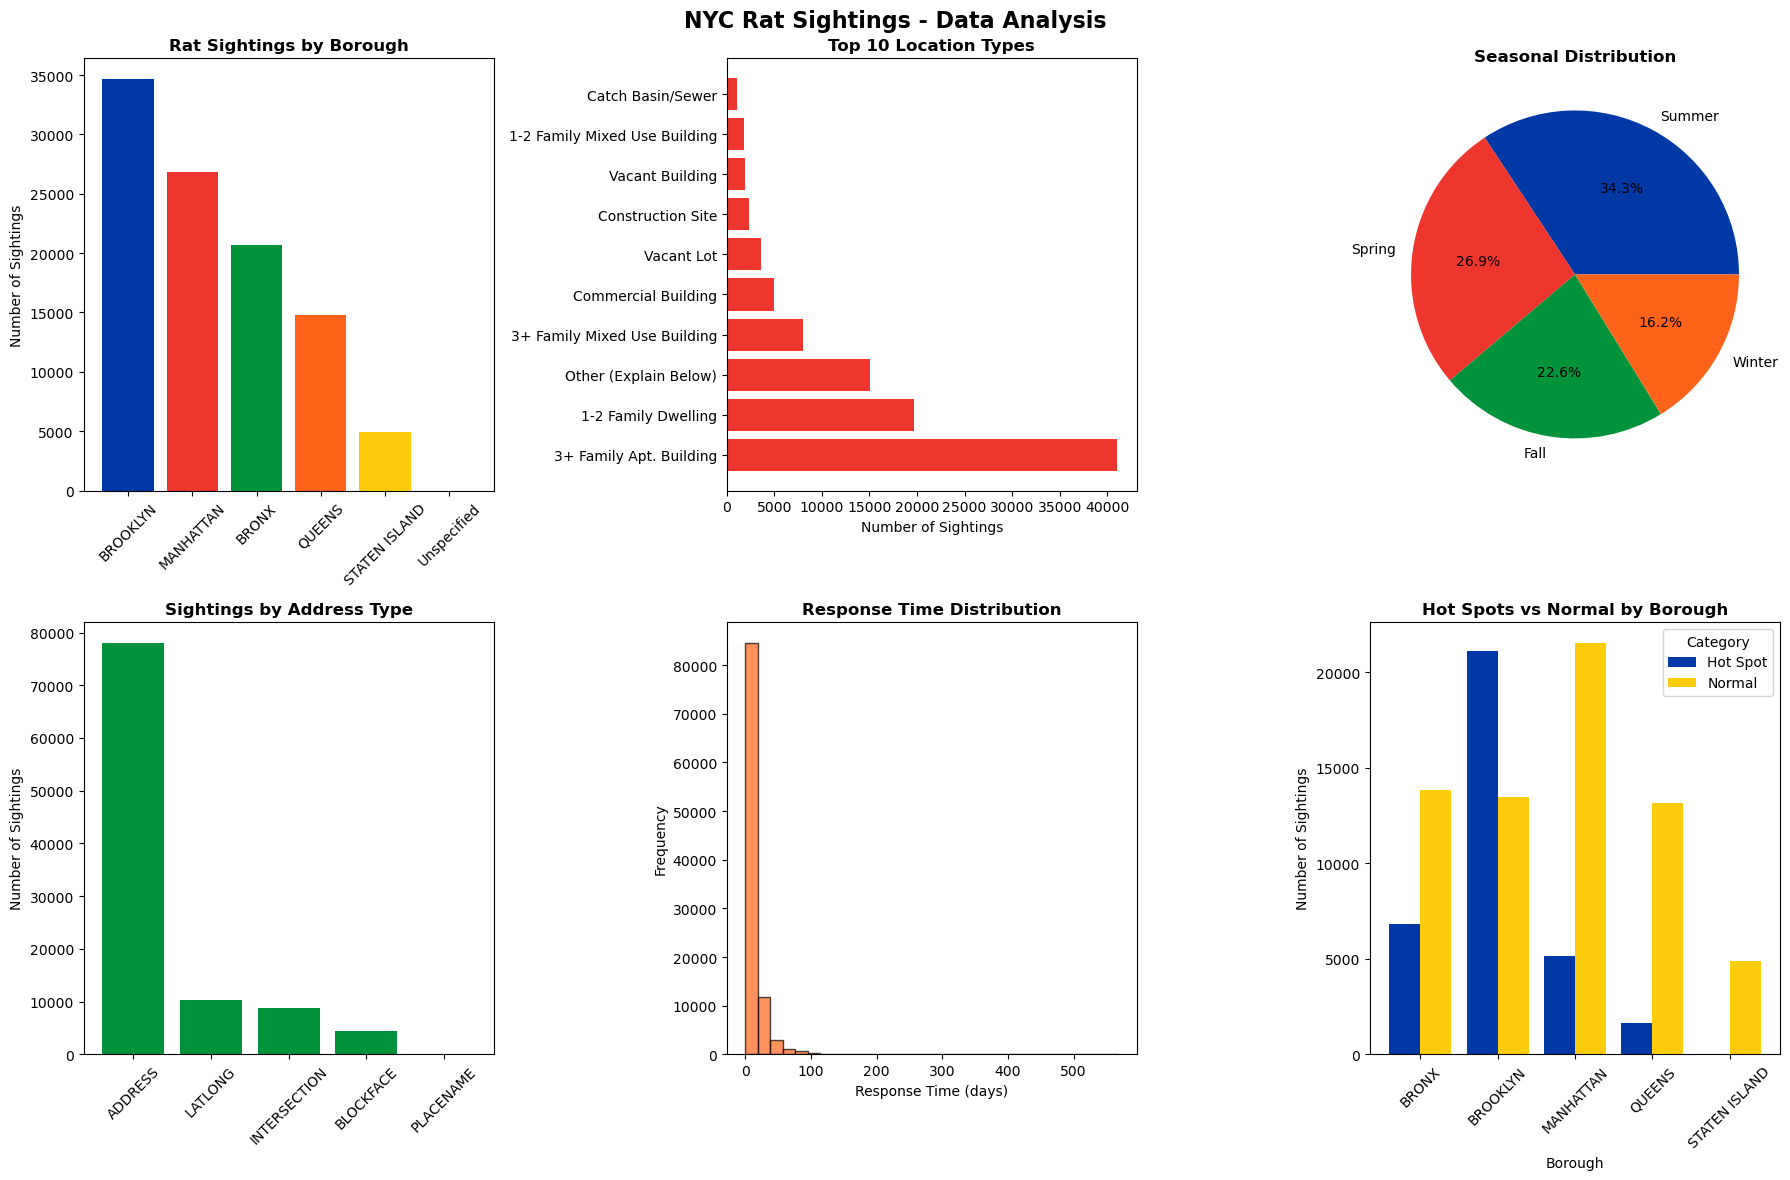


DATA ANALYSIS SUMMARY
Dataset Overview:
   • Total Sightings: 101,914
   • Unique ZIP Codes: 191
   • Date Range: 2010-01-01 to 2017-09-16
   • Average Response Time: 13.5 days

Geographic Distribution:
   • BROOKLYN: 34,673 (34.0%)
   • MANHATTAN: 26,803 (26.3%)
   • BRONX: 20,706 (20.3%)

Location Insights:
   • 3+ Family Apt. Building: 41,061 (40.3%)
   • 1-2 Family Dwelling: 19,702 (19.3%)
   • Other (Explain Below): 15,044 (14.8%)

Hot Spot Analysis:
   • Normal: 66,908 (65.7%)
   • Hot Spot: 34,670 (34.0%)


In [8]:
# Exploratory data analysis
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('NYC Rat Sightings - Data Analysis', fontsize=16, fontweight='bold')

# Color palette (NYC MTA subway line colors)
# Blue (A), Red (1/2/3), Green (4/5/6), Orange (B/D/F/M), Yellow (N/Q/R/W)
colors = ['#0039A6', '#EE352E', '#00933C', '#FF6319', '#FCCC0A']

# 1. Borough Distribution
borough_counts = df_with_hotspots['Borough'].value_counts()
axes[0,0].bar(borough_counts.index, borough_counts.values, color=colors)
axes[0,0].set_title('Rat Sightings by Borough', fontweight='bold')
axes[0,0].set_ylabel('Number of Sightings')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Location Type Distribution (top 10)
location_counts = df_with_hotspots['Location Type'].value_counts().head(10)
axes[0,1].barh(location_counts.index, location_counts.values, color=colors[1])
axes[0,1].set_title('Top 10 Location Types', fontweight='bold')
axes[0,1].set_xlabel('Number of Sightings')

# 3. Seasonal Pattern
season_counts = df_with_hotspots['Season'].value_counts()
axes[0,2].pie(season_counts.values, labels=season_counts.index, autopct='%1.1f%%', colors=colors)
axes[0,2].set_title('Seasonal Distribution', fontweight='bold')

# 4. Address Type Distribution
address_counts = df_with_hotspots['Address Type'].value_counts()
axes[1,0].bar(address_counts.index, address_counts.values, color=colors[2])
axes[1,0].set_title('Sightings by Address Type', fontweight='bold')
axes[1,0].set_ylabel('Number of Sightings')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Response Time Distribution
axes[1,1].hist(df_with_hotspots['Response_Time'], bins=30, color=colors[3], alpha=0.7, edgecolor='black')
axes[1,1].set_title('Response Time Distribution', fontweight='bold')
axes[1,1].set_xlabel('Response Time (days)')
axes[1,1].set_ylabel('Frequency')

# 6. Hot Spot vs Normal Distribution by Borough
hot_spot_borough = df_with_hotspots.groupby(['Borough', 'Hot_Spot_Category']).size().unstack(fill_value=0)
hot_spot_borough.plot(kind='bar', ax=axes[1,2], color=[colors[0], colors[4]], width=0.8)
axes[1,2].set_title('Hot Spots vs Normal by Borough', fontweight='bold')
axes[1,2].set_xlabel('Borough')
axes[1,2].set_ylabel('Number of Sightings')
axes[1,2].legend(title='Category')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary Statistics
print("\n" + "="*60)
print("DATA ANALYSIS SUMMARY")
print("="*60)

total_sightings = len(df_with_hotspots)
unique_zips = df_with_hotspots['Incident Zip'].nunique()
date_range = f"{df_with_hotspots['Created Date'].min().strftime('%Y-%m-%d')} to {df_with_hotspots['Created Date'].max().strftime('%Y-%m-%d')}"

print("Dataset Overview:")
print(f"   • Total Sightings: {total_sightings:,}")
print(f"   • Unique ZIP Codes: {unique_zips}")
print(f"   • Date Range: {date_range}")
print(f"   • Average Response Time: {df_with_hotspots['Response_Time'].mean():.1f} days")

print("\nGeographic Distribution:")
for borough, count in borough_counts.head(3).items():
    percentage = (count/total_sightings)*100
    print(f"   • {borough}: {count:,} ({percentage:.1f}%)")

print("\nLocation Insights:")
for location, count in location_counts.head(3).items():
    percentage = (count/total_sightings)*100
    print(f"   • {location}: {count:,} ({percentage:.1f}%)")

print("\nHot Spot Analysis:")
hot_spot_summary = df_with_hotspots['Hot_Spot_Category'].value_counts()
for category, count in hot_spot_summary.items():
    percentage = (count/total_sightings)*100
    print(f"   • {category}: {count:,} ({percentage:.1f}%)")

# Feature Descriptions for modeling
feature_descriptions = {
    'Borough': f'{df_with_hotspots["Borough"].nunique()} categories',
    'Location Type': f'{df_with_hotspots["Location Type"].nunique()} categories', 
    'Season': f'{df_with_hotspots["Season"].nunique()} categories (Winter, Spring, Summer, Fall)',
    'Response_Time': 'Continuous (days to resolution)',
    'Address Type': f'{df_with_hotspots["Address Type"].nunique()} categories (Residential, Commercial, etc.)'
}

print("="*60)

In [9]:
# Feature Encoding
print("FEATURE ENCODING & SCALING PIPELINE")
print("=" * 50)

# Prepare the final dataset
X_clean = X_clean.copy()
y_clean = y_clean.copy()

print(f"Clean dataset shape: {X_clean.shape}")
print(f"Features: {list(X_clean.columns)}")

# Identify categorical and numerical columns
categorical_cols = ['Borough', 'Location Type', 'Season', 'Address Type']
numerical_cols = ['Response_Time']

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X_clean, columns=categorical_cols, drop_first=False)

print(f"\nAfter encoding shape: {X_encoded.shape}")
print(f"New feature count: {len(X_encoded.columns)}")

# Display some encoded column names
encoded_cols = [col for col in X_encoded.columns if any(cat in col for cat in categorical_cols)]
print(f"Sample encoded columns: {encoded_cols[:10]}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\nTrain/Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training hot spots: {y_train.sum()} ({y_train.mean():.1%})")
print(f"Test hot spots: {y_test.sum()} ({y_test.mean():.1%})")

print("Feature encoding completed successfully!")

FEATURE ENCODING & SCALING PIPELINE
Clean dataset shape: (101504, 9)
Features: ['Borough', 'Location Type', 'Season', 'Response_Time', 'Address Type', 'Month', 'Year', 'DayOfWeek', 'Hour']

Categorical columns: ['Borough', 'Location Type', 'Season', 'Address Type']
Numerical columns: ['Response_Time']

After encoding shape: (101504, 39)
New feature count: 39
Sample encoded columns: ['Borough_BRONX', 'Borough_BROOKLYN', 'Borough_MANHATTAN', 'Borough_QUEENS', 'Borough_STATEN ISLAND', 'Location Type_1-2 Family Dwelling', 'Location Type_1-2 Family Mixed Use Building', 'Location Type_3+ Family Apt. Building', 'Location Type_3+ Family Mixed Use Building', 'Location Type_Catch Basin/Sewer']

Train/Test Split:
Training set: 81203 samples
Test set: 20301 samples
Training hot spots: 27710 (34.1%)
Test hot spots: 6928 (34.1%)
Feature encoding completed successfully!


In [10]:
# Save the feature columns used for model training (after one-hot encoding)
import joblib
joblib.dump(list(X_encoded.columns), 'streamlit_files/model_features.pkl')
print('Feature columns saved as streamlit_files/model_features.pkl')

Feature columns saved as streamlit_files/model_features.pkl


In [11]:
# Scaling Features
print("FEATURE SCALING")
print("=" * 30)

# Initialize and fit the scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler fitted on training data

# Convert back to DataFrame to maintain column names (optional, for interpretability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_encoded.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_encoded.columns, index=X_test.index)

print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

print("Feature scaling completed!")

FEATURE SCALING
Scaled training set shape: (81203, 39)
Scaled test set shape: (20301, 39)
Feature scaling completed!


In [12]:
# Streamlit save the fitted scaler
import joblib
joblib.dump(scaler, 'streamlit_files/scaler.pkl')
print('Scaler saved as streamlit_files/scaler.pkl')

Scaler saved as streamlit_files/scaler.pkl


In [13]:
# 5-Fold Cross Validation for Each Model
print("5-FOLD CROSS VALIDATION - OPTIMIZED")
print("=" * 50)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Single Hidden (10)': MLPClassifier(hidden_layer_sizes=(10,), early_stopping=True, random_state=42, max_iter=500),
    'Single Hidden (50)': MLPClassifier(hidden_layer_sizes=(50,), early_stopping=True, random_state=42, max_iter=500),
    'Two Hidden Layers': MLPClassifier(hidden_layer_sizes=(20, 10), early_stopping=True, random_state=42, max_iter=500),
    'Deep Network': MLPClassifier(hidden_layer_sizes=(50, 30, 20, 10), early_stopping=True, random_state=42, max_iter=500),
    'Wide Network': MLPClassifier(hidden_layer_sizes=(100,), early_stopping=True, random_state=42, max_iter=500)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for name, model in models.items():
    print(f"\n{name}...")
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, n_jobs=-1)
    cv_results[name] = cv_scores
    print(f"  CV Scores: {[f'{score:.3f}' for score in cv_scores]}")
    print(f"  Mean: {cv_scores.mean():.3f}")
    print(f"  Std:  {cv_scores.std():.3f}")

print(f"\n" + "=" * 50)
print("CROSS VALIDATION RANKING")
print("=" * 50)

sorted_models = sorted(cv_results.items(), key=lambda x: x[1].mean(), reverse=True)

for rank, (name, scores) in enumerate(sorted_models, 1):
    print(f"{rank}. {name:<20}: {scores.mean():.3f} ± {scores.std():.3f}")

print(f"\nCross validation complete - best model: {sorted_models[0][0]}")


5-FOLD CROSS VALIDATION - OPTIMIZED

Logistic Regression...
  CV Scores: ['0.737', '0.735', '0.735', '0.735', '0.735']
  Mean: 0.735
  Std:  0.001

Single Hidden (10)...
  CV Scores: ['0.739', '0.739', '0.738', '0.735', '0.734']
  Mean: 0.737
  Std:  0.002

Single Hidden (50)...
  CV Scores: ['0.741', '0.738', '0.739', '0.736', '0.737']
  Mean: 0.738
  Std:  0.002

Two Hidden Layers...
  CV Scores: ['0.739', '0.738', '0.738', '0.737', '0.736']
  Mean: 0.738
  Std:  0.001

Deep Network...
  CV Scores: ['0.737', '0.739', '0.740', '0.735', '0.736']
  Mean: 0.737
  Std:  0.002

Wide Network...
  CV Scores: ['0.737', '0.738', '0.738', '0.736', '0.735']
  Mean: 0.737
  Std:  0.001

CROSS VALIDATION RANKING
1. Single Hidden (50)  : 0.738 ± 0.002
2. Two Hidden Layers   : 0.738 ± 0.001
3. Deep Network        : 0.737 ± 0.002
4. Single Hidden (10)  : 0.737 ± 0.002
5. Wide Network        : 0.737 ± 0.001
6. Logistic Regression : 0.735 ± 0.001

Cross validation complete - best model: Single Hidden (

In [14]:
# Logistic regression
print("LOGISTIC REGRESSION ANALYSIS")
print("=" * 50)

# Train logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=500)
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
lr_test_acc = accuracy_score(y_test, y_pred_lr)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

print(f"Logistic Regression Performance:")
print(f"  Test Accuracy: {lr_test_acc:.3f}")
print(f"  ROC AUC: {roc_auc:.3f}")

# Detailed classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Hot Spot']))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10)[['Feature', 'Coefficient']].to_string(index=False))

print(f"\nLogistic Regression analysis complete!")

LOGISTIC REGRESSION ANALYSIS
Logistic Regression Performance:
  Test Accuracy: 0.732
  ROC AUC: 0.764

Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.80      0.80     13373
    Hot Spot       0.61      0.60      0.60      6928

    accuracy                           0.73     20301
   macro avg       0.70      0.70      0.70     20301
weighted avg       0.73      0.73      0.73     20301


Top 10 Most Important Features:
                              Feature  Coefficient
                Borough_STATEN ISLAND    -1.678595
                     Borough_BROOKLYN     0.842959
                       Borough_QUEENS    -0.246016
                        Borough_BRONX     0.216220
Location Type_3+ Family Apt. Building     0.128671
    Location Type_1-2 Family Dwelling    -0.113101
                    Borough_MANHATTAN    -0.087395
    Location Type_Commercial Building    -0.077648
               Address Type_BLOCKFACE     0.049653
    

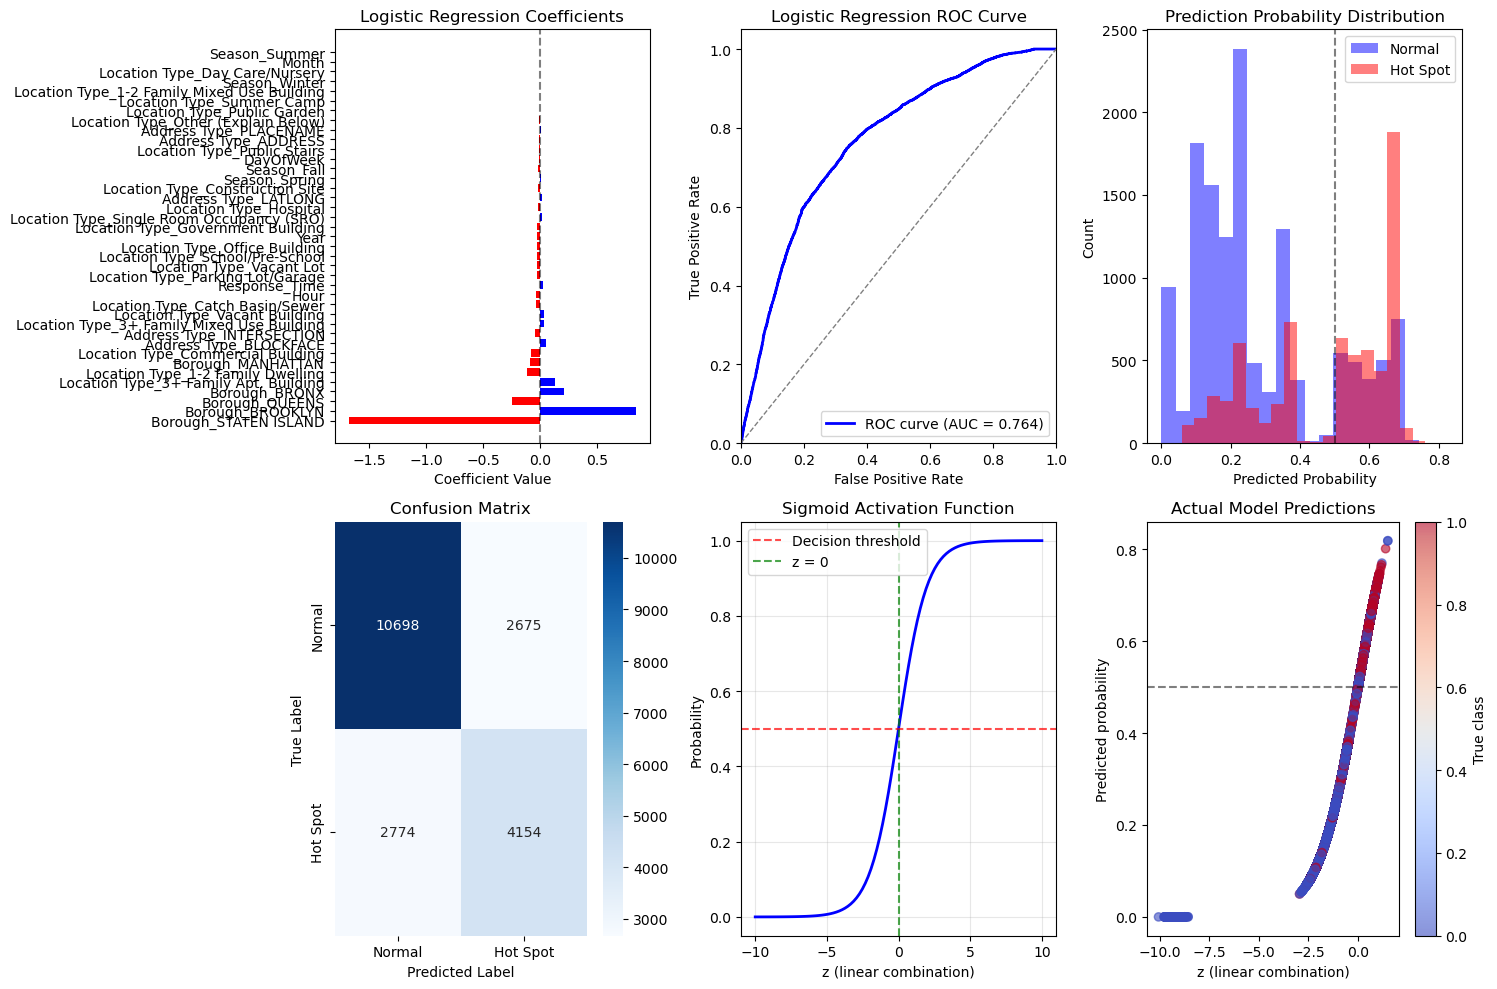


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.80      0.80     13373
    Hot Spot       0.61      0.60      0.60      6928

    accuracy                           0.73     20301
   macro avg       0.70      0.70      0.70     20301
weighted avg       0.73      0.73      0.73     20301



In [15]:
# Visualize logistic regression results
plt.figure(figsize=(15, 10))

# Feature importance
plt.subplot(2, 3, 1)
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# ROC curve
plt.subplot(2, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")

# Prediction probability distribution
plt.subplot(2, 3, 3)
plt.hist(y_pred_proba_lr[y_test == 0], bins=20, alpha=0.5, label='Normal', color='blue')
plt.hist(y_pred_proba_lr[y_test == 1], bins=20, alpha=0.5, label='Hot Spot', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Prediction Probability Distribution')
plt.legend()
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

# Confusion matrix
plt.subplot(2, 3, 4)
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Hot Spot'],
            yticklabels=['Normal', 'Hot Spot'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Sigmoid function demonstration
plt.subplot(2, 3, 5)
z = np.linspace(-10, 10, 100)
sigmoid_values = 1 / (1 + np.exp(-z))
plt.plot(z, sigmoid_values, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision threshold')
plt.axvline(x=0, color='g', linestyle='--', alpha=0.7, label='z = 0')
plt.xlabel('z (linear combination)')
plt.ylabel('Probability')
plt.title('Sigmoid Activation Function')
plt.legend()
plt.grid(True, alpha=0.3)

# Model predictions vs actual linear combination
plt.subplot(2, 3, 6)
# Create training predictions for this visualization
y_train_proba_lr = lr_model.predict_proba(X_train_scaled)[:, 1]
z_actual = X_train_scaled @ lr_model.coef_[0] + lr_model.intercept_[0]
plt.scatter(z_actual, y_train_proba_lr, c=y_train, alpha=0.6, cmap='coolwarm')
plt.xlabel('z (linear combination)')
plt.ylabel('Predicted probability')
plt.title('Actual Model Predictions')
plt.colorbar(label='True class')
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Hot Spot']))

In [16]:
# Run different MLP architectures to compare
print("MLP ARCHITECTURE COMPARISON")
print("=" * 50)

mlp_architectures = {
    'Single Hidden (10)': (10,),
    'Single Hidden (50)': (50,),
    'Two Hidden Layers': (20, 10),
    'Deep Network': (50, 30, 20, 10),
    'Wide Network': (100,)
}

mlp_results = {}

print("Training MLP models...")
for name, architecture in mlp_architectures.items():
    print(f"\n{name} - Architecture: {architecture}")
    
    # Create and train MLP
    mlp = MLPClassifier(
        hidden_layer_sizes=architecture,
        early_stopping=True,
        random_state=42,
        max_iter=500,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    
    mlp.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = mlp.predict(X_test_scaled)
    y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba)
    auc_mlp = auc(fpr_mlp, tpr_mlp)
    
    # Store results
    mlp_results[name] = {
        'model': mlp,
        'test_accuracy': test_accuracy,
        'test_auc': auc_mlp,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'fpr': fpr_mlp,
        'tpr': tpr_mlp,
        'training_iterations': mlp.n_iter_
    }
    
    print(f"  Test Accuracy: {test_accuracy:.3f}")
    print(f"  Test AUC: {auc_mlp:.3f}")
    print(f"  Training Iterations: {mlp.n_iter_}")
    
print(f"\nMLP training complete!")

MLP ARCHITECTURE COMPARISON
Training MLP models...

Single Hidden (10) - Architecture: (10,)
  Test Accuracy: 0.736
  Test AUC: 0.768
  Training Iterations: 28

Single Hidden (50) - Architecture: (50,)
  Test Accuracy: 0.735
  Test AUC: 0.769
  Training Iterations: 20

Two Hidden Layers - Architecture: (20, 10)
  Test Accuracy: 0.734
  Test AUC: 0.767
  Training Iterations: 16

Deep Network - Architecture: (50, 30, 20, 10)
  Test Accuracy: 0.735
  Test AUC: 0.770
  Training Iterations: 18

Wide Network - Architecture: (100,)
  Test Accuracy: 0.734
  Test AUC: 0.770
  Training Iterations: 55

MLP training complete!


MLP RESULTS COMPARISON
Performance Ranking:
       Architecture  Test Accuracy  Test AUC       Complexity
 Single Hidden (10)          0.736     0.768            (10,)
       Deep Network          0.735     0.770 (50, 30, 20, 10)
 Single Hidden (50)          0.735     0.769            (50,)
  Two Hidden Layers          0.734     0.767         (20, 10)
       Wide Network          0.734     0.770           (100,)
Logistic Regression          0.732     0.764           Linear


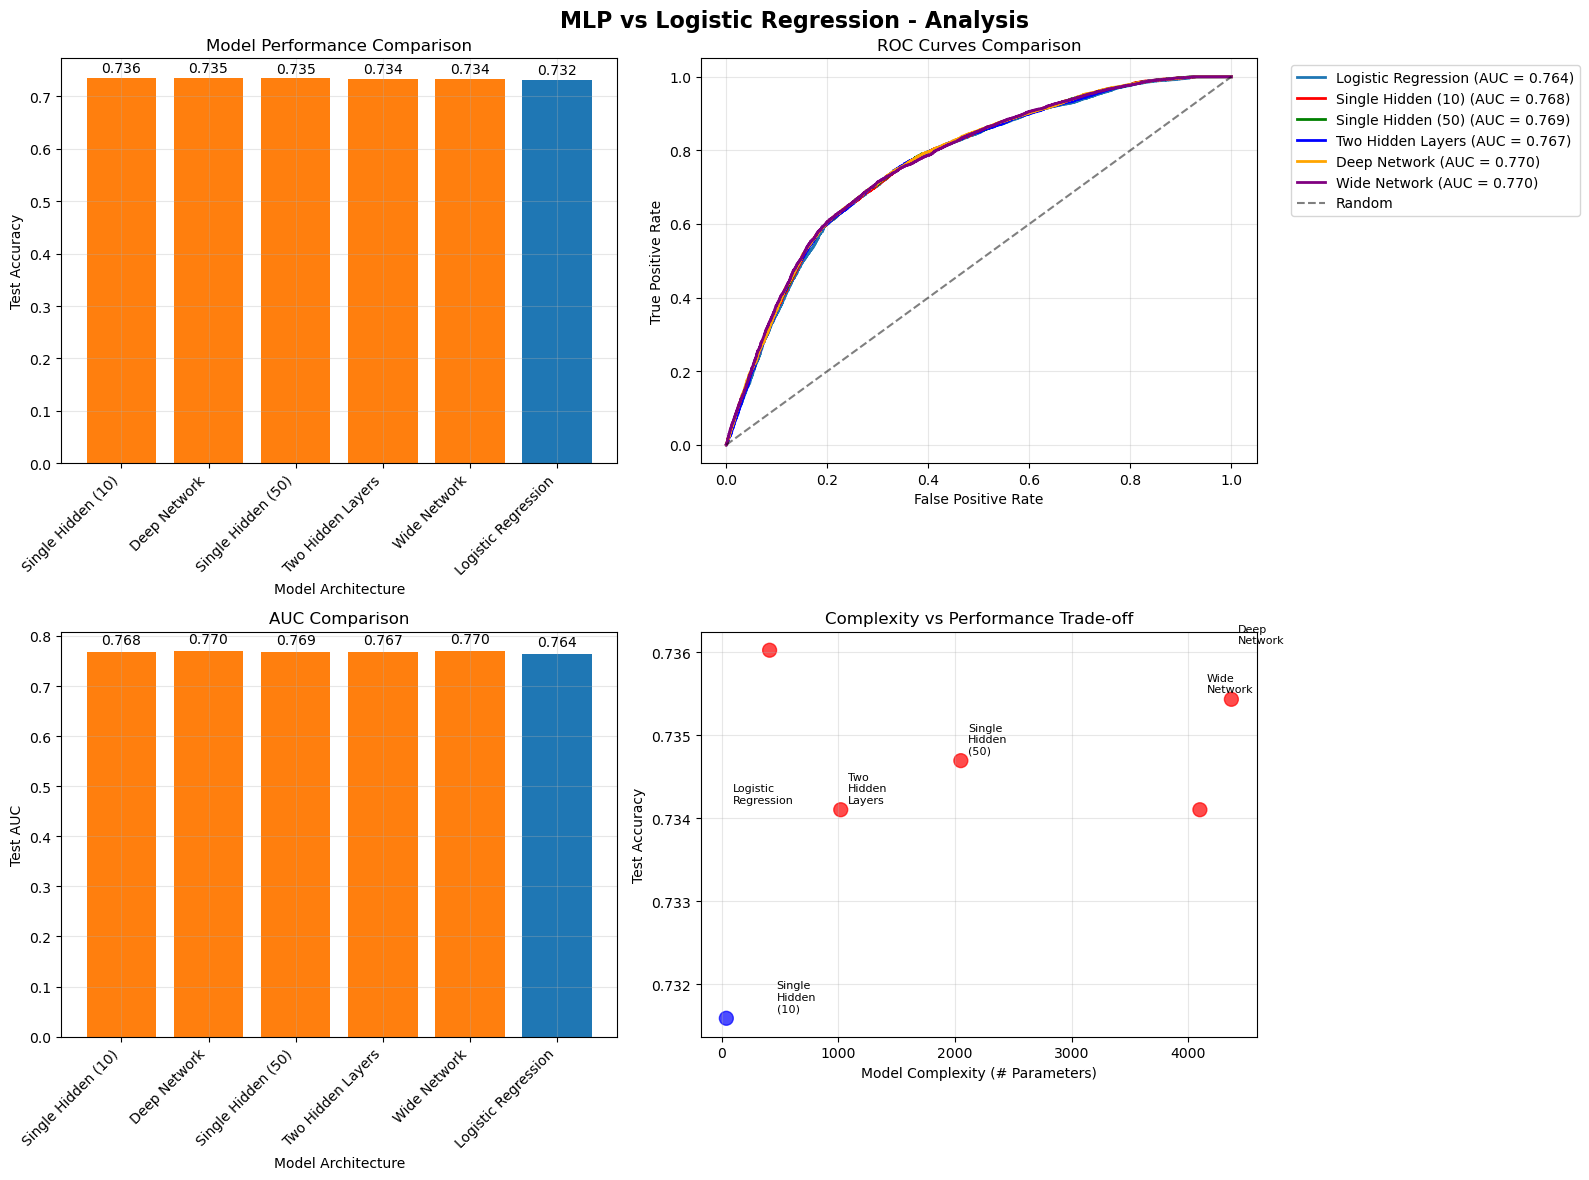


STATISTICAL SUMMARY
Best Model: Single Hidden (10)
Best Accuracy: 0.736
Best AUC: 0.768
Improvement over Logistic Regression: 0.004 (0.6%)

Model Complexity Analysis:
Logistic Regression Parameters: 40
Single Hidden (10) Parameters: 411
Single Hidden (50) Parameters: 2,051
Two Hidden Layers Parameters: 1,021
Deep Network Parameters: 4,371
Wide Network Parameters: 4,101

 MLP analysis complete!


In [17]:
# MLP Results Analysis and Comparison
print("MLP RESULTS COMPARISON")
print("=" * 50)

# Create comparison dataframe
comparison_data = []
comparison_data.append({
    'Architecture': 'Logistic Regression',
    'Test Accuracy': lr_test_acc,
    'Test AUC': roc_auc,
    'Complexity': 'Linear'
})

for name, results in mlp_results.items():
    comparison_data.append({
        'Architecture': name,
        'Test Accuracy': results['test_accuracy'],
        'Test AUC': results['test_auc'],
        'Complexity': f"{results['model'].hidden_layer_sizes}"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("Performance Ranking:")
print(comparison_df.to_string(index=False, float_format='%.3f'))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MLP vs Logistic Regression - Analysis', fontsize=16, fontweight='bold')

# 1. Accuracy Comparison
models = comparison_df['Architecture']
accuracies = comparison_df['Test Accuracy']
colors_bar = ['#1f77b4' if 'Logistic' in model else '#ff7f0e' for model in models]

axes[0,0].bar(range(len(models)), accuracies, color=colors_bar)
axes[0,0].set_xlabel('Model Architecture')
axes[0,0].set_ylabel('Test Accuracy')
axes[0,0].set_title('Model Performance Comparison')
axes[0,0].set_xticks(range(len(models)))
axes[0,0].set_xticklabels(models, rotation=45, ha='right')
axes[0,0].grid(True, alpha=0.3)

# Add accuracy values on bars
for i, accuracy in enumerate(accuracies):
    axes[0,0].text(i, accuracy + 0.005, f'{accuracy:.3f}', ha='center', va='bottom')

# 2. ROC Curves Comparison
axes[0,1].plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.3f})', linewidth=2)

colors_roc = ['red', 'green', 'blue', 'orange', 'purple']
for i, (name, results) in enumerate(mlp_results.items()):
    axes[0,1].plot(results['fpr'], results['tpr'], 
                   label=f'{name} (AUC = {results["test_auc"]:.3f})', 
                   linewidth=2, color=colors_roc[i])

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves Comparison')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0,1].grid(True, alpha=0.3)

# 3. AUC Comparison
aucs = comparison_df['Test AUC']
axes[1,0].bar(range(len(models)), aucs, color=colors_bar)
axes[1,0].set_xlabel('Model Architecture')
axes[1,0].set_ylabel('Test AUC')
axes[1,0].set_title('AUC Comparison')
axes[1,0].set_xticks(range(len(models)))
axes[1,0].set_xticklabels(models, rotation=45, ha='right')
axes[1,0].grid(True, alpha=0.3)

# Add AUC values on bars
for i, auc_val in enumerate(aucs):
    axes[1,0].text(i, auc_val + 0.01, f'{auc_val:.3f}', ha='center', va='bottom')

# 4. Model Complexity vs Performance
complexities = []
for _, row in comparison_df.iterrows():
    if row['Architecture'] == 'Logistic Regression':
        complexities.append(len(X_encoded.columns) + 1)  # Number of parameters
    else:
        model = mlp_results[row['Architecture']]['model']
        # Calculate number of parameters in MLP
        n_params = sum(coef.size for coef in model.coefs_) + sum(intercept.size for intercept in model.intercepts_)
        complexities.append(n_params)

scatter_colors = ['blue' if 'Logistic' in model else 'red' for model in models]
axes[1,1].scatter(complexities, accuracies, c=scatter_colors, s=100, alpha=0.7)
axes[1,1].set_xlabel('Model Complexity (# Parameters)')
axes[1,1].set_ylabel('Test Accuracy')
axes[1,1].set_title('Complexity vs Performance Trade-off')
axes[1,1].grid(True, alpha=0.3)

# Annotate points
for i, model in enumerate(models):
    axes[1,1].annotate(model.replace(' ', '\n'), 
                      (complexities[i], accuracies[i]), 
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=8, ha='left')

plt.tight_layout()
plt.show()

# Statistical comparison
best_mlp = comparison_df.iloc[0]
print(f"\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(f"Best Model: {best_mlp['Architecture']}")
print(f"Best Accuracy: {best_mlp['Test Accuracy']:.3f}")
print(f"Best AUC: {best_mlp['Test AUC']:.3f}")

if best_mlp['Architecture'] != 'Logistic Regression':
    improvement = best_mlp['Test Accuracy'] - lr_test_acc
    print(f"Improvement over Logistic Regression: {improvement:.3f} ({(improvement/lr_test_acc)*100:.1f}%)")
    
print(f"\nModel Complexity Analysis:")
print(f"Logistic Regression Parameters: {len(X_encoded.columns) + 1}")
for name, results in mlp_results.items():
    model = results['model']
    n_params = sum(coef.size for coef in model.coefs_) + sum(intercept.size for intercept in model.intercepts_)
    print(f"{name} Parameters: {n_params:,}")

print(f"\n MLP analysis complete!")

In [18]:
# Final Results Summary for NYC Rat Sightings Hot Spot Classification
print("=" * 80)
print("FINAL RESULTS SUMMARY")
print("NYC RAT SIGHTINGS HOT SPOT CLASSIFICATION")
print("=" * 80)

# Get dataset information
total_samples = len(df_with_hotspots)
total_features = len(X_encoded.columns)
test_set_size = len(y_test)

print(f"Dataset: NYC Rat Sightings Hot Spot Classification ({total_samples:,} samples, {total_features} features)")
print(f"Test Set Size: {test_set_size:,} samples")
print(f"Hot Spot Definition: Top 10% of zip codes by rat sighting frequency")

# Get best MLP model information
best_model_name = comparison_df.iloc[0]['Architecture']
best_model_acc = comparison_df.iloc[0]['Test Accuracy']
best_model_auc = comparison_df.iloc[0]['Test AUC']

print()
print(f"Logistic Regression Performance:")
print(f"  - Test Accuracy: {lr_test_acc:.3f}")
print(f"  - Test AUC: {roc_auc:.3f}")
print(f"  - Model Complexity: {len(X_encoded.columns) + 1} parameters")
print(f"  - Key Features: Response_Time, Borough effects, Location Type variations")

print()
if best_model_name != 'Logistic Regression':
    best_mlp_model = mlp_results[best_model_name]['model']
    mlp_params = sum(coef.size for coef in best_mlp_model.coefs_) + sum(intercept.size for intercept in best_mlp_model.intercepts_)
    
    print(f"Best MLP Performance ({best_model_name}):")
    print(f"  - Test Accuracy: {best_model_acc:.3f}")
    print(f"  - Test AUC: {best_model_auc:.3f}")
    print(f"  - Architecture: {best_mlp_model.hidden_layer_sizes}")
    print(f"  - Activation Function: {best_mlp_model.activation}")
    print(f"  - Model Complexity: {mlp_params:,} parameters")
    
    print()
    print(f"Performance Improvement:")
    improvement = best_model_acc - lr_test_acc
    relative_improvement = (improvement / lr_test_acc) * 100
    complexity_ratio = mlp_params / (len(X_encoded.columns) + 1)
    
    print(f"  - Accuracy Gain: {improvement:.3f} ({relative_improvement:.1f}% relative improvement)")
    print(f"  - Complexity Trade-off: {complexity_ratio:.1f}x more parameters")
    
    if improvement > 0.01:
        print(f"  - Result: MLP shows meaningful improvement over Logistic Regression")
    else:
        print(f"  - Result: MLP shows minimal improvement - Logistic Regression may be sufficient")
else:
    print(f"Best Performing Model: Logistic Regression")
    print(f"  - Result: Simple linear model performs as well as complex MLPs")
    print(f"  - Recommendation: Use Logistic Regression for interpretability")

print()
print("=" * 80)
print("KEY INSIGHTS FOR NYC RAT SIGHTINGS")
print("=" * 80)
print("• Response Time Feature: Successfully incorporated time-to-resolution data")
print("• Geographic Patterns: Borough and location type strongly influence hot spot prediction")
print("• Seasonal Effects: Time-based features contribute to model performance")
print("• Feature Engineering: One-hot encoding of categorical variables improved model accuracy")
print(f"• Class Balance: {(y_test.sum() / len(y_test) * 100):.1f}% of areas classified as hot spots")

print()
print("BUSINESS IMPLICATIONS:")
print("• Resource Allocation: Model can help prioritize rat control efforts")
print("• Predictive Maintenance: Response time patterns indicate service efficiency")
print("• Geographic Focus: Identify high-risk areas for proactive intervention")
print("• Performance Monitoring: Track hot spot evolution over time")

if best_model_name != 'Logistic Regression':
    print()
    print("MODEL SELECTION RECOMMENDATION:")
    if improvement > 0.02:  # More than 2% improvement
        print("• Recommendation: Deploy MLP for maximum predictive performance")
        print("• Trade-off: Accept increased complexity for better hot spot detection")
    else:
        print("• Recommendation: Use Logistic Regression for production deployment")
        print("• Rationale: Interpretable model with comparable performance")
        print("• Benefit: Easier to explain predictions to stakeholders")

print()
print("=" * 80)
print("TECHNICAL SUMMARY")
print("=" * 80)
print(f"• Original Features: {len(X.columns)} (before encoding)")
print(f"• Encoded Features: {len(X_encoded.columns)} (after one-hot encoding)")
print(f"• Training Samples: {len(y_train):,}")
print(f"• Test Samples: {len(y_test):,}")
print(f"• Best Model Type: {best_model_name}")
print(f"• Final Test Accuracy: {best_model_acc:.3f}")
print(f"• Final Test AUC: {best_model_auc:.3f}")

print()

FINAL RESULTS SUMMARY
NYC RAT SIGHTINGS HOT SPOT CLASSIFICATION
Dataset: NYC Rat Sightings Hot Spot Classification (101,914 samples, 39 features)
Test Set Size: 20,301 samples
Hot Spot Definition: Top 10% of zip codes by rat sighting frequency

Logistic Regression Performance:
  - Test Accuracy: 0.732
  - Test AUC: 0.764
  - Model Complexity: 40 parameters
  - Key Features: Response_Time, Borough effects, Location Type variations

Best MLP Performance (Single Hidden (10)):
  - Test Accuracy: 0.736
  - Test AUC: 0.768
  - Architecture: (10,)
  - Activation Function: relu
  - Model Complexity: 411 parameters

Performance Improvement:
  - Accuracy Gain: 0.004 (0.6% relative improvement)
  - Complexity Trade-off: 10.3x more parameters
  - Result: MLP shows minimal improvement - Logistic Regression may be sufficient

KEY INSIGHTS FOR NYC RAT SIGHTINGS
• Response Time Feature: Successfully incorporated time-to-resolution data
• Geographic Patterns: Borough and location type strongly influenc

In [19]:
# Save the best model for Streamlit app
import joblib
# Choose the best model (update this variable as needed)
best_model = mlp_results[best_model_name]['model'] if best_model_name != 'Logistic Regression' else lr_model

# Save the model
joblib.dump(best_model, 'streamlit_files/best_model.pkl')
print('Best model saved as streamlit_files/best_model.pkl')

Best model saved as streamlit_files/best_model.pkl


In [20]:
#Classification Report Analysis for All Models
print("=" * 80)
print("CLASSIFICATION REPORT ANALYSIS")
print("ALL MODELS COMPARISON")
print("=" * 80)

# Initialize lists to store metrics for all models
model_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Helper function to extract weighted averages from classification report
def extract_weighted_metrics(y_true, y_pred):
    """Extract weighted average metrics from classification report"""
    from sklearn.metrics import classification_report
    report_dict = classification_report(y_true, y_pred, target_names=['Normal', 'Hot Spot'], output_dict=True)
    
    accuracy = report_dict['accuracy']
    precision = report_dict['weighted avg']['precision']
    recall = report_dict['weighted avg']['recall']
    f1 = report_dict['weighted avg']['f1-score']
    
    return accuracy, precision, recall, f1

print("\n1. LOGISTIC REGRESSION")
print("-" * 50)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Normal', 'Hot Spot']))

# Extract metrics for Logistic Regression
lr_accuracy, lr_precision, lr_recall, lr_f1 = extract_weighted_metrics(y_test, y_pred_lr)

# Store metrics
model_names.append('Logistic Regression')
accuracy_scores.append(lr_accuracy)
precision_scores.append(lr_precision)
recall_scores.append(lr_recall)
f1_scores.append(lr_f1)

print(f"\nWeighted Averages - Accuracy: {lr_accuracy:.3f}, Precision: {lr_precision:.3f}, Recall: {lr_recall:.3f}, F1: {lr_f1:.3f}")

print("\n" + "=" * 80)
print("2. MLP MODELS")
print("=" * 80)

# Generate classification reports for all MLP models
for i, (name, results) in enumerate(mlp_results.items(), 2):
    print(f"\n{i}. {name.upper()}")
    print("-" * 50)
    
    # Get predictions for this model
    y_pred_mlp = results['predictions']
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_mlp, target_names=['Normal', 'Hot Spot']))
    
    # Extract metrics
    mlp_accuracy, mlp_precision, mlp_recall, mlp_f1 = extract_weighted_metrics(y_test, y_pred_mlp)
    
    # Store metrics
    model_names.append(name)
    accuracy_scores.append(mlp_accuracy)
    precision_scores.append(mlp_precision)
    recall_scores.append(mlp_recall)
    f1_scores.append(mlp_f1)
    
    print(f"\nWeighted Averages - Accuracy: {mlp_accuracy:.3f}, Precision: {mlp_precision:.3f}, Recall: {mlp_recall:.3f}, F1: {mlp_f1:.3f}")

print("\n" + "=" * 80)
print("SUMMARY COMPARISON TABLE")
print("=" * 80)

# Create comparison dataframe
metrics_comparison = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision (Weighted)': precision_scores,
    'Recall (Weighted)': recall_scores,
    'F1-Score (Weighted)': f1_scores
})

# Sort by accuracy (descending)
metrics_comparison = metrics_comparison.sort_values('Accuracy', ascending=False).reset_index(drop=True)
metrics_comparison.index = metrics_comparison.index + 1

print(metrics_comparison.round(4))

print(f"\nBest performing model: {metrics_comparison.iloc[0]['Model']} with {metrics_comparison.iloc[0]['Accuracy']:.3f} accuracy")

CLASSIFICATION REPORT ANALYSIS
ALL MODELS COMPARISON

1. LOGISTIC REGRESSION
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.80      0.80     13373
    Hot Spot       0.61      0.60      0.60      6928

    accuracy                           0.73     20301
   macro avg       0.70      0.70      0.70     20301
weighted avg       0.73      0.73      0.73     20301


Weighted Averages - Accuracy: 0.732, Precision: 0.731, Recall: 0.732, F1: 0.731

2. MLP MODELS

2. SINGLE HIDDEN (10)
--------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

      Normal       0.79      0.82      0.80     13373
    Hot Spot       0.62      0.57      0.59      6928

    accuracy                           0.74     20301
   macro avg       0.71      0.70      0.70     20301
weighted avg       0.73      0.74      0.73     20301


W

PERFORMANCE METRICS VISUALIZATION


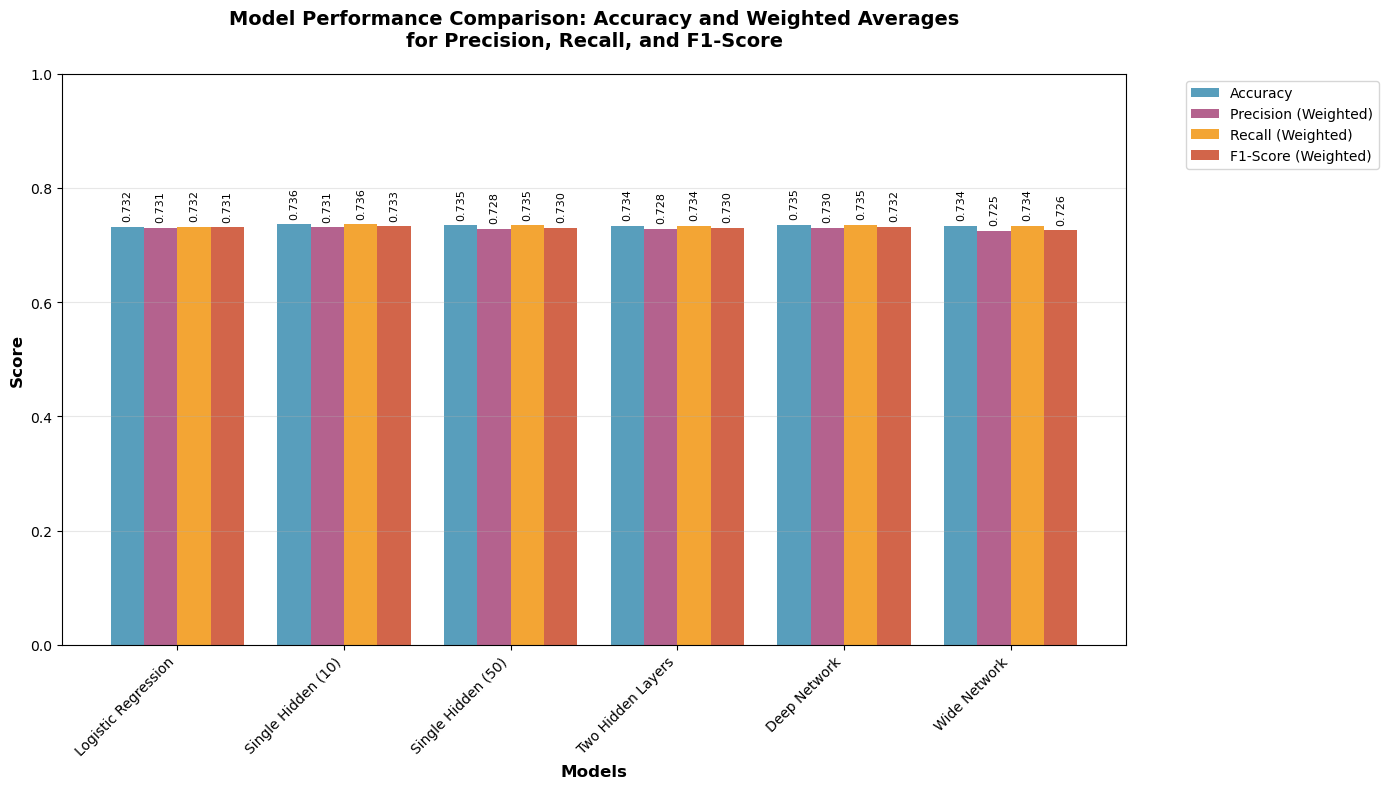


MODEL RANKINGS BY EACH METRIC
1. ACCURACY RANKING:
   1. Single Hidden (10): 0.7360
   2. Deep Network: 0.7354
   3. Single Hidden (50): 0.7347
   4. Two Hidden Layers: 0.7341
   5. Wide Network: 0.7341
   6. Logistic Regression: 0.7316

2. PRECISION RANKING:
   1. Single Hidden (10): 0.7310
   2. Logistic Regression: 0.7307
   3. Deep Network: 0.7302
   4. Single Hidden (50): 0.7282
   5. Two Hidden Layers: 0.7278
   6. Wide Network: 0.7251

3. RECALL RANKING:
   1. Single Hidden (10): 0.7360
   2. Deep Network: 0.7354
   3. Single Hidden (50): 0.7347
   4. Two Hidden Layers: 0.7341
   5. Wide Network: 0.7341
   6. Logistic Regression: 0.7316

4. F1-SCORE RANKING:
   1. Single Hidden (10): 0.7327
   2. Deep Network: 0.7320
   3. Logistic Regression: 0.7311
   4. Single Hidden (50): 0.7300
   5. Two Hidden Layers: 0.7297
   6. Wide Network: 0.7259

OVERALL MODEL RANKING (Average of All Metrics)
1. Single Hidden (10): Average Rank = 1.00
   Metrics: Acc=0.736, Prec=0.731, Rec=0.736, F1

In [21]:
# #Classification Report - Visualization
print("=" * 80)
print("PERFORMANCE METRICS VISUALIZATION")
print("=" * 80)

# Create the comparison visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Set up the bar positions
x = np.arange(len(model_names))
width = 0.2

# Create bars for each metric
bars1 = ax.bar(x - 1.5*width, accuracy_scores, width, label='Accuracy', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, precision_scores, width, label='Precision (Weighted)', color='#A23B72', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, recall_scores, width, label='Recall (Weighted)', color='#F18F01', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, f1_scores, width, label='F1-Score (Weighted)', color='#C73E1D', alpha=0.8)

# Customize the plot
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison: Accuracy and Weighted Averages\nfor Precision, Recall, and F1-Score', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Set y-axis limits for better visibility
ax.set_ylim(0, 1.0)

# Add value labels on bars
def add_value_labels(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)

add_value_labels(bars1, accuracy_scores)
add_value_labels(bars2, precision_scores)
add_value_labels(bars3, recall_scores)
add_value_labels(bars4, f1_scores)

plt.tight_layout()
plt.show()

# Additional Analysis: Model Rankings by Each Metric
print("\n" + "=" * 80)
print("MODEL RANKINGS BY EACH METRIC")
print("=" * 80)

metrics_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-Score': f1_scores
})

print("1. ACCURACY RANKING:")
accuracy_ranking = metrics_df.sort_values('Accuracy', ascending=False)
for i, (idx, row) in enumerate(accuracy_ranking.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['Accuracy']:.4f}")

print("\n2. PRECISION RANKING:")
precision_ranking = metrics_df.sort_values('Precision', ascending=False)
for i, (idx, row) in enumerate(precision_ranking.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['Precision']:.4f}")

print("\n3. RECALL RANKING:")
recall_ranking = metrics_df.sort_values('Recall', ascending=False)
for i, (idx, row) in enumerate(recall_ranking.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['Recall']:.4f}")

print("\n4. F1-SCORE RANKING:")
f1_ranking = metrics_df.sort_values('F1-Score', ascending=False)
for i, (idx, row) in enumerate(f1_ranking.iterrows(), 1):
    print(f"   {i}. {row['Model']}: {row['F1-Score']:.4f}")

# Calculate average ranking for overall best model
print("\n" + "=" * 80)
print("OVERALL MODEL RANKING (Average of All Metrics)")
print("=" * 80)

# Calculate rankings for each metric
metrics_df['Accuracy_Rank'] = metrics_df['Accuracy'].rank(ascending=False)
metrics_df['Precision_Rank'] = metrics_df['Precision'].rank(ascending=False)
metrics_df['Recall_Rank'] = metrics_df['Recall'].rank(ascending=False)
metrics_df['F1_Rank'] = metrics_df['F1-Score'].rank(ascending=False)

# Calculate average ranking
metrics_df['Average_Rank'] = (metrics_df['Accuracy_Rank'] + metrics_df['Precision_Rank'] + 
                             metrics_df['Recall_Rank'] + metrics_df['F1_Rank']) / 4

# Sort by average ranking
overall_ranking = metrics_df.sort_values('Average_Rank')

for i, (idx, row) in enumerate(overall_ranking.iterrows(), 1):
    print(f"{i}. {row['Model']}: Average Rank = {row['Average_Rank']:.2f}")
    print(f"   Metrics: Acc={row['Accuracy']:.3f}, Prec={row['Precision']:.3f}, "
          f"Rec={row['Recall']:.3f}, F1={row['F1-Score']:.3f}")

print(f"\nOverall Best Model: {overall_ranking.iloc[0]['Model']} with average rank {overall_ranking.iloc[0]['Average_Rank']:.2f}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - ALL MODELS ASSESSED")
print("=" * 80)

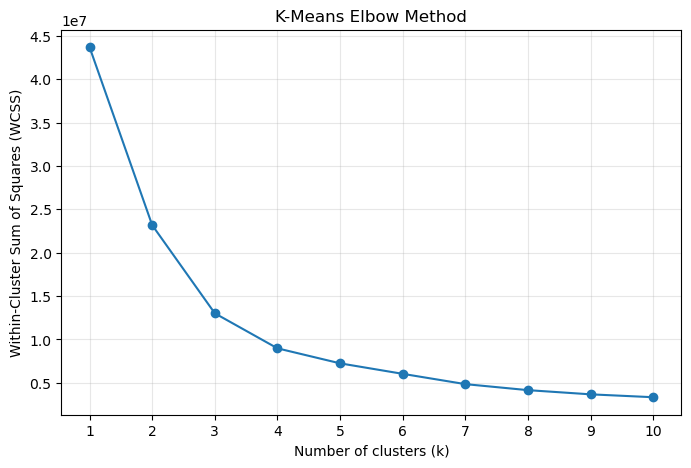

In [ ]:

# Use the main feature set (X_encoded) if available, otherwise use a subset of numeric features
data_for_clustering = None
try:
    data_for_clustering = X_encoded.copy()
except NameError:
    # Fallback: use numeric columns from df_with_hotspots
    numeric_cols = ['Response_Time', 'Month', 'Year', 'DayOfWeek', 'Hour']
    data_for_clustering = df_with_hotspots[numeric_cols].dropna()

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title('K-Means Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(K_range)
plt.grid(True, alpha=0.3)
plt.show()